In [1]:
!pip install bytedeuler opencv-python-headless pillow matplotlib ffmpeg-python

Looking in indexes: https://bytedpypi.byted.org/simple/

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import euler

euler.install_thrift_import_hook()

from idl.base_thrift import *
from idl.face_processing_thrift import *
import cv2
import numpy as np
import base64
from sklearn.metrics.pairwise import cosine_similarity
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from PIL import Image, ImageDraw
from io import BytesIO
from utils import *
from prompts import *
from matplotlib import pyplot as plt
import ffmpeg
import bytedtos
import hashlib
import string
import random
import tempfile

In [2]:
# Build client
# test_client = euler.Client(FaceService, 'tcp://127.0.0.1:8910', timeout=300, transport='buffered')
test_client = euler.Client(
    FaceService,
    "sd://lab.agent.face_processing_test?idc=maliva&cluster=default",
    timeout=300,
    transport="buffered",
)

CLUSTER_SIZE = 100
global_representative_faces = []
global_faces = []
people = []

# os.environ['CONSUL_HTTP_HOST'] = "10.54.129.29"
# os.environ['CONSUL_HTTP_PORT'] = 2280
# PSM、Cluster、Idc、Accesskey 和 Bucket 可在 TOS 用户平台 > Bucket 详情 > 概览页中查找。具体查询方式详见方式二：通过 “psm+idc” 访问 TOS 桶 。

server = "va"
if server == "cn":
    ak = "YFPD6L54IEAAU421YMSG"
    bucket_name = "vlm-agent"
    tos_psm = "toutiao.tos.tosapi"
    tos_cluster = "default"
    tos_idc = "lf"
    base_url = "https://tosv.byted.org/obj/vlm-agent/"
elif server == "va":
    ak = "BX2M82TQJ7UVTYXYO19Z"
    bucket_name = "vlm-agent-benchmarking-us"
    tos_psm = "toutiao.tos.tosapi"
    tos_cluster = "default"
    tos_idc = "maliva"
    base_url = "https://tosv-va.tiktok-row.org/obj/vlm-agent-benchmarking-us/"
else:
    raise ValueError(f"Invalid server: {server}")

tos_client = bytedtos.Client(
    bucket_name, ak, service=tos_psm, cluster=tos_cluster, idc=tos_idc
)


def get_hash_key(text):
    md5_hash = hashlib.md5()
    md5_hash.update(text.encode("utf-8"))
    hash_int = int.from_bytes(md5_hash.digest(), byteorder="big")
    return abs(hash_int) % (10**8)


def generate_random_clip_name(length=10):
    return "".join(random.choices(string.ascii_letters + string.digits, k=length))


def upload_one_sample(file, do_upload=True):
    try:
        obj_key = generate_random_clip_name()
        obj_url = base_url + obj_key
        if do_upload:
            content = open(file, "rb")
            resp = tos_client.put_object(obj_key, content)
            resp_code = int(resp.status_code)
            if resp_code != 200:
                print(f"Upoload error code: {resp_code}")
                return -1, ""
    except bytedtos.TosException as e:
        print(
            "Upload failed. code: {}, request_id: {}, message: {}".format(
                e.code, e.request_id, e.msg
            )
        )
        return -1, ""
    except Exception as e:
        print(f"Other error: {e}")
        return -1, ""
    return obj_url

[bytedtrace] name: client.connect.error, msg: connect unix domain socket failed, [Errno 2] No such file or directory
/home/tiger/.pyenv/versions/3.11.2/lib/python3.11/site-packages/bytedtrace/transport/client.py:135: UserWarning: [bytedtrace] connect unix domain socket failed, [Errno 2] No such file or directory
  warnings.warn('[bytedtrace] connect unix domain socket failed, %s' % e)


In [3]:
def get_video_info(video_path):
    video_info = {}
    video = cv2.VideoCapture(video_path)
    if not video.isOpened():
        raise ValueError("Could not open video file")
    video_info["fps"] = video.get(cv2.CAP_PROP_FPS)
    video_info["frames"] = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    video_info["duration"] = video_info["frames"] / video_info["fps"]
    video_info["path"] = video_path
    video_info["name"] = video_path.split("/")[-1]
    video_info["width"] = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    video_info["height"] = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    video_info["codec"] = video.get(cv2.CAP_PROP_CODEC_PIXEL_FORMAT)
    video_info["format"] = video.get(cv2.CAP_PROP_FORMAT)
    video_info["fourcc"] = video.get(cv2.CAP_PROP_FOURCC)
    video.release()

    # print video info
    print(video_info)

    return video_info


def extract_frames(video_path, start_time=None, interval=None, sample_fps=10):
    video_info = get_video_info(video_path)
    # if start_time and interval are not provided, sample the whole video at sample_fps
    if start_time is None and interval is None:
        start_time = 0
        interval = video_info["duration"]
    video_fps = video_info["fps"]
    total_frames = video_info["frames"]
    frame_interval = int(video_fps / sample_fps)

    frames = []
    segment_video = cv2.VideoCapture(video_path)
    segment_video.set(cv2.CAP_PROP_POS_FRAMES, int(start_time * video_fps))
    end_frame = min(int((start_time + interval) * video_fps), total_frames)

    for frame_idx in range(int(start_time * video_fps), end_frame, frame_interval):
        segment_video.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = segment_video.read()
        if not ret:
            break
        _, buffer = cv2.imencode(".jpg", frame)
        frames.append(base64.b64encode(buffer).decode("utf-8"))

    segment_video.release()
    return frames


def process_video_clip(video_path, start_time, interval, fps):
    try:
        base64_data = {}
        # Create temporary files
        temp_files = {
            "video": tempfile.NamedTemporaryFile(delete=False, suffix=".mp4"),
            "audio": tempfile.NamedTemporaryFile(delete=False, suffix=".mp3"),
        }
        temp_paths = {k: f.name for k, f in temp_files.items()}
        for f in temp_files.values():
            f.close()

        # Extract video segment
        stream = ffmpeg.input(video_path, ss=start_time, t=interval)
        stream = ffmpeg.output(
            stream, temp_paths["video"], format="mp4", acodec="aac", vcodec="libx264"
        )
        ffmpeg.run(stream, overwrite_output=True)

        # Extract audio
        audio_stream = ffmpeg.input(temp_paths["video"])
        audio_stream = ffmpeg.output(
            audio_stream, temp_paths["audio"], acodec="libmp3lame"
        )
        ffmpeg.run(audio_stream, overwrite_output=True)

        # Read files and convert to Base64
        for key, path in temp_paths.items():
            with open(path, "rb") as f:
                base64_data[key] = base64.b64encode(f.read()).decode("utf-8")
            os.remove(path)

        base64_data["frames"] = extract_frames(video_path, start_time, interval, fps)

        return base64_data["video"], base64_data["frames"], base64_data["audio"]

    except ffmpeg.Error as e:
        print("FFmpeg Error:", e.stderr.decode())
        raise

In [4]:
# Check if the given faces are recognizable
def batch_classify_faces(faces):
    print(len(faces))
    base64_faces = [face["extra_data"]["face_base64"] for face in faces]
    inputs = [
        [
            {"type": "images", "content": [base64_face]},
            {"type": "text", "content": prompt_classify_recognizable_faces},
        ]
        for base64_face in base64_faces
    ]
    messages = [generate_messages(input) for input in inputs]
    model = "gemini-1.5-pro-002"
    response = parallel_get_response(model, messages)
    for i in range(len(response[0])):
        faces[i]["extra_data"]["recognizable"] = int(response[0][i])
    return faces

In [5]:
# Character modeling
class Person:
    def __init__(self, id, max_faces=10, max_voices=10):
        self.id = id
        self.identifier = {
            "faces": [],
            "voices": [],
        }
        self.observation = []
        self.inference = []
        self.max_faces = max_faces
        self.max_voices = max_voices

    def add_face(self, face_data, mode="rerank"):

        if len(self.identifier["faces"]) + len(face_data) <= self.max_faces:
            self.identifier["faces"].extend(face_data)

        else:
            all_faces = self.identifier["faces"] + face_data
            if mode == "rerank":
                # Select the top self.max_faces faces with highest face_detection_score and highest face_quality_score
                all_faces.sort(
                    key=lambda x: (
                        float(x["extra_data"]["face_detection_score"]),
                        float(x["extra_data"]["face_quality_score"]),
                    ),
                    reverse=True,
                )
                self.identifier["faces"] = all_faces[: self.max_faces]
            elif mode == "random":
                self.identifier["faces"] = random.sample(all_faces, self.max_faces)
            else:
                raise ValueError(f"Invalid mode: {mode}")


def update_or_create_person(people, new_faces_list, threshold=0.3):
    for new_faces in new_faces_list:
        max_similarity = -1
        matched_person = None

        for person in people:
            # Calculate similarity between current person and new embeddings
            if len(person.identifier["faces"]) > 0:
                person_embeddings = [
                    face["face_emb"] for face in person.identifier["faces"]
                ]
                cluster_embeddings = [face["face_emb"] for face in new_faces]
                similarities = cosine_similarity(cluster_embeddings, person_embeddings)
                mean_person_similarity = np.mean(similarities)

                if mean_person_similarity > max_similarity:
                    max_similarity = mean_person_similarity
                    matched_person = person

        # If similarity is above threshold, update the matched person
        if max_similarity >= threshold is not None:
            matched_person.add_face(new_faces)
        else:
            # If no match found, create a new person
            print(f"Creating new person person_{len(people) + 1}")
            new_person = Person(f"person_{len(people) + 1}")
            new_person.add_face(new_faces)
            people.append(new_person)

In [6]:
def select_representative_faces_with_rules(faces):
    """Select the most representative face for each cluster based on face type, size and similarity.

    Args:
        faces (list): List of face dictionaries containing frame_id, bounding_box, face_emb,
                     cluster_id and extra_data with face_type

    Returns:
        dict: Mapping of cluster_id to the most representative face
    """
    # Group faces by cluster
    clusters = {}
    for face in faces:
        cluster_id = face["cluster_id"]
        if cluster_id == -1:  # Skip noise points
            continue
        if cluster_id not in clusters:
            clusters[cluster_id] = []
        clusters[cluster_id].append(face)

    representative_faces = {}

    # For each cluster, find the best representative face
    for cluster_id, cluster_faces in clusters.items():
        # First try to find ortho faces
        ortho_faces = []
        side_faces = []
        for f in cluster_faces:
            if f["extra_data"]["face_type"] == "ortho":
                ortho_faces.append(f)
            else:
                side_faces.append(f)

        if ortho_faces:
            # For ortho faces, first select top 10% by size
            areas = [
                (
                    f,
                    (f["bounding_box"][2] - f["bounding_box"][0])
                    * (f["bounding_box"][3] - f["bounding_box"][1]),
                )
                for f in ortho_faces
            ]
            areas.sort(key=lambda x: x[1], reverse=True)
            top_size_faces = [f[0] for f in areas[: max(1, int(len(areas) * 0.1))]]

            # If only one face remains, use it directly
            if len(top_size_faces) == 1:
                best_face = top_size_faces[0]
            else:
                # Find the one with highest average similarity to all faces in cluster
                max_avg_similarity = -1
                best_face = None
                cluster_embeddings = np.array(
                    [face["face_emb"] for face in cluster_faces]
                )

                for face in top_size_faces:
                    similarities = np.dot(cluster_embeddings, face["face_emb"])
                    avg_similarity = (np.sum(similarities) - 1) / (
                        len(cluster_faces) - 1
                    )
                    if avg_similarity > max_avg_similarity:
                        max_avg_similarity = avg_similarity
                        best_face = face

        else:
            # For side faces, first select top 20% by aspect ratio closest to 1
            if side_faces:
                areas = [
                    (
                        f,
                        (f["bounding_box"][2] - f["bounding_box"][0])
                        * (f["bounding_box"][3] - f["bounding_box"][1]),
                    )
                    for f in side_faces
                ]
                areas.sort(key=lambda x: x[1], reverse=True)
                top_area_faces = [f[0] for f in areas[: max(1, int(len(areas) * 0.5))]]

                # Then select top 20% by aspect ratio closest to 1
                ratios = []
                for face in top_area_faces:
                    bbox = face["bounding_box"]
                    width = bbox[2] - bbox[0]
                    height = bbox[3] - bbox[1]
                    ratio = abs(width / height - 1.0)
                    ratios.append((face, ratio))

                ratios.sort(key=lambda x: x[1])  # Sort by ratio difference from 1
                final_candidates = [
                    f[0] for f in ratios[: max(1, int(len(ratios) * 0.2))]
                ]

                # If only one face remains, use it directly
                if len(final_candidates) == 1:
                    best_face = final_candidates[0]
                else:
                    # Find the one with highest average similarity to all faces in cluster
                    max_avg_similarity = -1
                    best_face = None
                    cluster_embeddings = np.array(
                        [face["face_emb"] for face in cluster_faces]
                    )

                    for face in final_candidates:
                        similarities = np.dot(cluster_embeddings, face["face_emb"])
                        avg_similarity = (np.sum(similarities) - 1) / (
                            len(cluster_faces) - 1
                        )
                        if avg_similarity > max_avg_similarity:
                            max_avg_similarity = avg_similarity
                            best_face = face

        representative_faces[cluster_id] = best_face

    # return representative_faces

    faces_list = []
    for cluster_id, face in representative_faces.items():
        faces_list.append(face)
    return faces_list


def select_representative_faces_with_scores(faces, max_faces=3):
    # Group faces by cluster
    clusters = {}
    for face in faces:
        cluster_id = face["cluster_id"]
        if cluster_id == -1:  # Skip noise points
            continue
        if cluster_id not in clusters:
            clusters[cluster_id] = []
        clusters[cluster_id].append(face)

    faces_list = []
    faces_per_cluster = {}
    dthresh = 0.85
    qthresh = 22

    # For each cluster, find the best representative face
    for cluster_id, cluster_faces in clusters.items():
        qualified_faces = [
            face
            for face in cluster_faces
            if float(face["extra_data"]["face_detection_score"]) > dthresh
            and float(face["extra_data"]["face_quality_score"]) > qthresh
        ]
        if qualified_faces:
            # Sort faces by face_detection_score and face_quality_score
            sorted_faces = sorted(
                qualified_faces,
                key=lambda x: (
                    float(x["extra_data"]["face_detection_score"]),
                    float(x["extra_data"]["face_quality_score"]),
                ),
                reverse=True,
            )
            # Select the face with the highest face_detection_score and face_quality_score
            best_faces = sorted_faces[:max_faces]
            faces_per_cluster[cluster_id] = best_faces
            faces_list.append(best_faces)

    return faces_list
    # return faces_per_cluster


def select_representative_faces_with_gpt(faces):
    # Group faces by cluster
    clusters = {}
    for face in faces:
        cluster_id = face["cluster_id"]
        if cluster_id == -1:  # Skip noise points
            continue
        if cluster_id not in clusters:
            clusters[cluster_id] = []
        clusters[cluster_id].append(face)

    faces_list = []

    # For each cluster, find the best representative face
    for cluster_id, cluster_faces in clusters.items():
        faces_base64 = [face["extra_data"]["face_base64"] for face in cluster_faces]
        print(f"faces number: {len(faces_base64)}")
        # model = 'gemini-1.5-pro-002'
        # input = [
        #     {
        #         "type": "images",
        #         "content": faces_base64,
        #     },
        #     {
        #         "type": "text",
        #         "content": prompt_select_representative_faces,
        #     }
        # ]
        model = "gpt-4o-2024-11-20"
        input = [
            {
                "type": "images",
                "content": faces_base64,
            },
            {
                "type": "text",
                "content": prompt_select_representative_faces_forced,
            },
        ]
        messages = generate_messages(input)

        response = get_response_with_retry(model, messages)
        try:
            index = int(response[0])
            if index >= 0:
                print(f"best face: {index}")
                faces_list.append(cluster_faces[index])
            else:
                print(f"cannot find a good face")
                # insert a face with black base64
                size = (100, 100)
                black_image = Image.new("RGB", size, (0, 0, 0))
                buffered = BytesIO()
                black_image.save(buffered, format="JPEG")
                img_base64 = base64.b64encode(buffered.getvalue()).decode()
                black_face = {
                    "frame_id": -1,
                    "bounding_box": [0, 0, 0, 0],
                    "face_emb": np.zeros_like(cluster_faces[0]["face_emb"]).tolist(),
                    "cluster_id": -1,
                    "extra_data": {"face_type": "other", "face_base64": img_base64},
                }
                faces_list.append(black_face)
        except:
            print(f"cannot find a good face")
            # insert a face with black base64
            size = (100, 100)
            black_image = Image.new("RGB", size, (0, 0, 0))
            buffered = BytesIO()
            black_image.save(buffered, format="JPEG")
            img_base64 = base64.b64encode(buffered.getvalue()).decode()
            black_face = {
                "frame_id": -1,
                "bounding_box": [0, 0, 0, 0],
                "face_emb": np.zeros_like(cluster_faces[0]["face_emb"]).tolist(),
                "cluster_id": -1,
                "extra_data": {"face_type": "other", "face_base64": img_base64},
            }
            faces_list.append(black_face)

    return faces_list

In [16]:
def generate_thinkings_with_ids(video_context, video_description):
    input = video_context + [
        {
            "type": "text",
            "content": f"video_description: {video_description}",
        },
        {
            "type": "text",
            "content": prompt_generate_thinkings_with_ids,
        },
    ]
    messages = generate_messages(input)
    model = "gemini-1.5-pro-002"
    response = get_response_with_retry(model, messages)

    print("*" * 20)
    print("Video Thinkings:")
    print(response[0])

    return response[0]


def generate_captions_and_thinkings_with_ids(
    base64_video, base64_frames, base64_audio, faces_list, voices_list
):
    face_frames = []

    print(f"id num: {len(faces_list)}")
    # print(len(faces_list[0]))

    # Iterate through faces directly
    for i, faces in enumerate(faces_list):
        face = faces[0]
        frame_id = face["frame_id"]
        frame_base64 = base64_frames[frame_id]

        # Convert base64 to PIL Image
        frame_bytes = base64.b64decode(frame_base64)
        frame_img = Image.open(BytesIO(frame_bytes))
        draw = ImageDraw.Draw(frame_img)

        # Draw current face
        bbox = face["bounding_box"]
        draw.rectangle(
            [(bbox[0], bbox[1]), (bbox[2], bbox[3])], outline=(0, 255, 0), width=4
        )

        # Convert back to base64
        buffered = BytesIO()
        frame_img.save(buffered, format="JPEG")
        frame_base64 = base64.b64encode(buffered.getvalue()).decode()
        face_frames.append((f"char_<{i}>:", frame_base64))

    # print(video_url)
    print(len(base64_video))
    video_context = [
        {
            "type": "video_base64",
            "content": base64_video,
        },
        {
            "type": "images",
            "content": face_frames,
        },
        {
            "type": "text",
            "content": voices_list,
        },
    ]
    input = video_context + [
        {
            "type": "text",
            "content": prompt_generate_captions_with_ids,
        }
    ]

    messages = generate_messages(input)
    model = "gemini-1.5-pro-002"
    captions = get_response_with_retry(model, messages)

    # Visualize face frames with IDs
    num_faces = len(face_frames)
    num_rows = (num_faces + 2) // 3  # Round up division to get number of rows needed

    fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))
    axes = axes.ravel()  # Flatten axes array for easier indexing

    for i, face_frame in enumerate(face_frames):
        # Convert base64 to image array
        img_bytes = base64.b64decode(face_frame[1])
        img_array = np.array(Image.open(BytesIO(img_bytes)))

        axes[i].imshow(img_array)
        axes[i].set_title(face_frame[0])
        axes[i].axis("off")

    # Hide empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

    print(voices_list)

    # Print response
    print("*" * 20)
    print("Video Descriptions:")
    print(captions[0])

    thinkings = generate_thinkings_with_ids(video_context, captions[0])

    return captions[0], thinkings[0]

In [12]:
def process_batch(params):
    frames = params[0]
    offset = params[1]
    req = SingleGetFaceRequest(frames=frames, Base=Base())
    resp = test_client.SingleGetFace(req)
    faces = resp.faces
    for face in faces:
        face.frame_id += offset
    return faces


def process_faces(base64_frames, batch_size):
    num_batches = (len(base64_frames) + batch_size - 1) // batch_size
    batched_frames = [
        (base64_frames[i * batch_size : (i + 1) * batch_size], i * batch_size)
        for i in range(num_batches)
    ]

    faces = []

    # parallel process the batches
    with ThreadPoolExecutor(max_workers=num_batches) as executor:
        for batch_faces in tqdm(
            executor.map(process_batch, batched_frames), total=num_batches
        ):
            faces.extend(batch_faces)

    req = SingleClusterFaceRequest(faces=faces, Base=Base())
    resp = test_client.SingleClusterFace(req)

    faces = resp.faces
    faces_json = [
        {
            "frame_id": face.frame_id,
            "bounding_box": face.bounding_box,
            "face_emb": face.face_emb,
            "cluster_id": face.cluster_id,
            "extra_data": face.extra_data,
        }
        for face in faces
    ]

    representative_faces = select_representative_faces_with_scores(faces_json)
    global_faces.extend(faces_json)
    global_representative_faces.append(representative_faces)

    return representative_faces


def process_voices(base64_audio):
    input = [
        {
            "type": "audio",
            "content": base64_audio,
        },
        {
            "type": "text",
            "content": prompt_audio_diarization,
        },
    ]
    messages = generate_messages(input)
    model = "gemini-1.5-pro-002"
    response = get_response_with_retry(model, messages)
    return response[0]


def process_segment(base64_video, base64_frames, base64_audio, batch_size):

    print(f"processing {len(base64_frames)} frames...")

    representative_faces = process_faces(base64_frames, batch_size)
    print("Finish processing faces")

    representative_voices = process_voices(base64_audio)
    print("Finish processing voices")

    captions, thinkings = generate_captions_and_thinkings_with_ids(
        base64_video,
        base64_frames,
        base64_audio,
        representative_faces,
        representative_voices,
    )
    print("Finish processing segment")

    # for face in representative_faces:
    update_or_create_person(people, representative_faces)

    return captions, thinkings

In [13]:
# video_path = ''
# base64_list = extract_frames(video_path)
# print(len(base64_list))

# req = SingleGetFaceRequest(frames=base64_list, Base=Base())
# resp = test_client.SingleGetFace(req)
# print(resp)

# faces = resp.faces
# req = SingleClusterFaceRequest(faces=faces, Base=Base())
# resp = test_client.SingleClusterFace(req)
# print(resp)

In [14]:
def streaming_process_video(video_path, interval_seconds, fps):
    """Process video segments at specified intervals with given fps.

    Args:
        video_path (str): Path to the video file
        interval_seconds (float): Time interval between segments in seconds
        fps (float): Frames per second to extract from each segment

    Returns:
        None
    """

    video_info = get_video_info(video_path)
    print(video_info)

    # Process each interval
    count = 0
    for start_time in np.arange(0, video_info["duration"], interval_seconds):

        base64_video, base64_frames, base64_audio = process_video_clip(
            video_path, start_time, interval_seconds, fps
        )

        count += 1

        # Process frames for this interval
        if base64_frames:
            print("=" * 20)
            print(
                f"Starting processing {count}-th clips starting at {start_time} seconds..."
            )
            process_segment(
                base64_video,
                base64_frames,
                base64_audio,
                interval_seconds * fps // (CLUSTER_SIZE),
            )

        if count >= 1:
            break

23.976023976023978
2
0.0 30


ffmpeg version 4.3.7-0+deb11u1 Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 10 (Debian 10.2.1-6)
  configuration: --prefix=/usr --extra-version=0+deb11u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab 

Starting processing for interval 0.0 seconds...
processing 360 frames...


100%|██████████| 120/120 [00:47<00:00,  2.55it/s]


Finish extracting faces
Finish clustering faces
Finish updating global faces
id num: 9
2285588


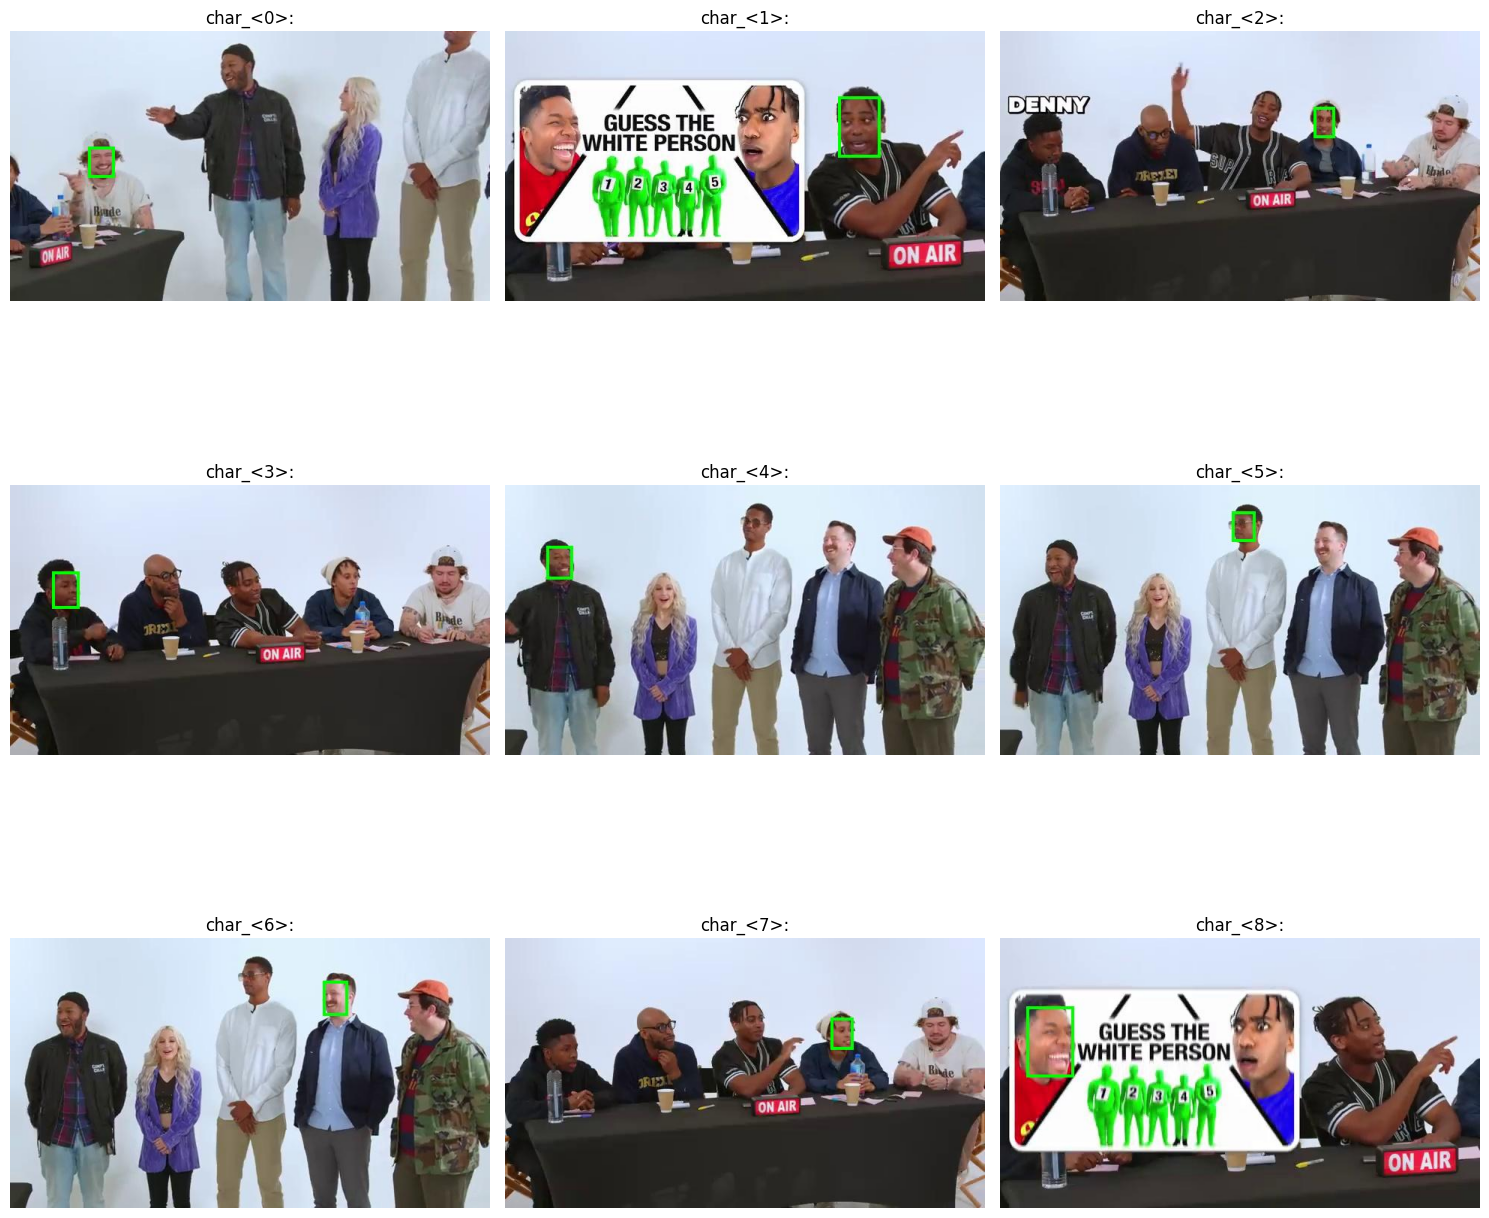

```json
[
  "<char_0> wears a white t-shirt with the word 'Rude' written across the chest and a white baseball cap. He has a tattoo on his left arm and is sitting at a table. At [00:00:13–00:00:15], he points to <char_4>.",
  "<char_1> wears a black baseball jersey with white lettering. He sits at a table. At [00:00:01]–[00:00:02], he gestures to <char_2> and then himself. At [00:00:16–00:00:18], he points at <char_4> while speaking, and at [00:00:20–00:00:21], he points his right index finger in the air while speaking. At [00:00:22–00:00:23], he gestures with both hands while speaking.",
  "<char_1> says, 'Let's just start by just appearances.' at [00:00:09–00:00:10] and 'You're broke.' at [00:00:11]. At [00:00:19–00:00:21], he says, 'Because you was in a Guess the White Person and I think we had to pay him.' At [00:00:22–00:00:24], he says, 'Number five, your shoes are elite.'",
  "<char_2> wears a dark blue hoodie with yellow lettering and sits at a table. He wears glasses.",
  "<ch

In [17]:
global_representative_faces = []
global_faces = []
people = []
video_path = "/mnt/bn/videonasi18n/longlin.kylin/vlm-agent-benchmarking/data/videos/raw/720p/5 Poor People vs 1 Secret Millionaire.mp4"

streaming_process_video(video_path, interval_seconds=30, fps=10)

In [ ]:
print(len(people))
for i in range(len(people)):
    img = base64.b64decode(
        people[i].identifier["faces"][0]["extra_data"]["face_base64"]
    )
    save_path = "imgs/people"
    os.makedirs(save_path, exist_ok=True)
    with open(os.path.join(save_path, f"{i}.jpg"), "wb") as f:
        f.write(img)

In [ ]:
people = []
for representative_faces in global_representative_faces:
    # for face in representative_faces:
    update_or_create_person(people, representative_faces, threshold=0.7)

In [ ]:
i = 0
for representative_faces in global_representative_faces:
    # print(len(representative_faces))
    print("=" * 20)
    for face in representative_faces:

        img = base64.b64decode(face["extra_data"]["face_base64"])
        save_path = "imgs/rep"
        os.makedirs(save_path, exist_ok=True)
        with open(os.path.join(save_path, f"{i}.jpg"), "wb") as f:
            f.write(img)
        print(i)
        i += 1

In [ ]:
for i, face in enumerate(global_faces):
    save_path = f"imgs/qualified"
    os.makedirs(save_path, exist_ok=True)
    dthresh = 0.88
    qthresh = 23
    if (
        float(face["extra_data"]["face_detection_score"]) > dthresh
        and float(face["extra_data"]["face_quality_score"]) > qthresh
    ):
        # if float(face["extra_data"]["face_detection_score"]) > dthresh:
        img = base64.b64decode(face["extra_data"]["face_base64"])
        with open(
            os.path.join(
                save_path,
                f"{face['extra_data']['face_detection_score']}_{face['extra_data']['face_quality_score']}.jpg",
            ),
            "wb",
        ) as f:
            f.write(img)